#### Building a model from a pretrained GloVe model
- Training your own model embedding model is possible however it frequently requires a lot of data
- What we more frequently do is start with an embedding model trained by Facebook, Google or Stanford and then either:
    1. Freeze the embedding layer - assuming the linguistic regularity of our corpus/documents matches that off the embeddings generated by the pretrained models
    2. Use the pretrained weights and update them for our model

- In this class we won't go over fitting skipgram, word2vec or GloVe models from scratch because they require a lot of data and computation resources
- For a more thorough exposition see the following links:
    - [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html)
    - [Python gensim Word2Vec tutorial with TensorFlow and Keras](http://adventuresinmachinelearning.com/gensim-word2vec-tutorial/)
    - [A Word2Vec Keras tutorial](http://adventuresinmachinelearning.com/word2vec-keras-tutorial/)
    - [Code example: Word2Vec (skipgram) in Keras with Gensim](https://github.com/nzw0301/keras-examples/blob/master/Skip-gram-with-NS.ipynb)
    

#### What we are going to be doing in this notebook
- In this notebook we'll go through using pretrained embeddings on our imdb data set
- When there isn't sufficient data, using some form of pre-trained mode is really beneficial (transfer learning)

- In sequence we will:
    - Download the raw imdb data set, unzip it, read it and assign pos/neg target values
    - Tokenize the imdb data set
    - Download GloVe word embeddings
    - Prepare the Glove word-embedding matrix
    - Setup our neural netowrk 
    - Load GloVe embedding in the model
        - Note we will freeze this layer so that it does not disrupt pre-trained weights
    - Training the model
    - Compare the model without pretrained word embeddings

### Setting up file imports for IMDB data
- Here we download the raw individual comments from IMDB users from -`https://www.kaggle.com/iarunava/imdb-movie-reviews-dataset`
- The file structure is such that you have:
    - /aclImdb -> (
        - /test -> 
            - (/neg,/pos, urls_neg.txt, url_post.txt), 
        - /train -> 
            - (/neg,/pos, urls_neg.txt, url_post.txt)))

In [1]:
# -- Import libraries --
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb
import numpy as np
import os
# Restrict to 10000 most common words
max_words = 10000

In [2]:
# LOAD IMDB DATA
(x_train_val, y_train_val), (x_test, y_test) = imdb.load_data(num_words = max_words)
max_val_word_index = max([max(sequence) for sequence in x_train_val])
max_length_review = max([len(sequence) for sequence in x_train_val])

# Printing output
print(" Train and Validation data {x}\n Train labels {y}".format(x = x_train_val.shape, y = y_train_val.shape))
print("_"*20)
print(" Test and Validation  data {x}\n Test labels {y}".format(x = x_test.shape, y = y_test.shape))
print("_"*20)
print("Maximum value of a word index {}".format(max_val_word_index))
print("Maximum length num words of review in train {}".format(max_length_review))


17465344/17464789 [==============================] - 14s 1us/step
 Train and Validation data (25000,)
 Train labels (25000,)
____________________
 Test and Validation  data (25000,)
 Test labels (25000,)
____________________
Maximum value of a word index 9999
Maximum length num words of review in train 2494


In [3]:
# --- Getting reviews ---
# Reverse from integers to words using the DICTIONARY (given by keras...need to do nothing to create it)
# note that words without a mapping are given by a "?"
word_index = imdb.get_word_index()

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in x_train_val[123]])

print(decoded_review)

1646592/1641221 [==============================] - 2s 1us/step
? beautiful and touching movie rich colors great settings good acting and one of the most charming movies i have seen in a while i never saw such an interesting setting when i was in china my wife liked it so much she asked me to ? on and rate it so other would enjoy too


In [4]:
# -- Parameter setup --
# Cutoff reviews after 100 words
maxlen = 100
# Train on 20000 samples
training_samples = 20000
# Validation on 5000 samples
validation_samples = 5000

In [5]:
# Padding/bounding number of words in a sequence
data = pad_sequences(x_train_val, maxlen = maxlen)
labels = np.asarray(y_train_val)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [6]:
# -- Shuffling indices --
np.random.seed(1234)
# Shuffling data set  because ordered
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
# --- Training and validation set ---
data = data[indices]
labels = labels[indices]

# - Setting up train/test split -
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:(training_samples + validation_samples)]
y_val = labels[training_samples:(training_samples + validation_samples)]

In [7]:
# Downloading the glove file
# WARNING - this is a big file, about 1GB.
import urllib
urllib.request.urlretrieve("http://nlp.stanford.edu/data/glove.6B.zip", '/tmp/glove')

('/tmp/glove', <http.client.HTTPMessage at 0x7f9b6e076550>)

In [8]:
import zipfile
zip_ref = zipfile.ZipFile("/tmp/glove", 'r')
zip_ref.extractall("/tmp/glove.6B")

#### Build a vector map 
- We are going to use a 100 dimensional glove embedding
- Before we do so we need to build a dictionary of words:vector_embeddings
- Next we build an index that maps words (as strings) to their vector represenation in 100D

In [9]:
# --- Parsing the GloVe word-embeddings file --
# After unzipping file 

glove_dir = os.path.join('/tmp/', 'glove.6B')

# Dictionary where we store the word:vector_embedding map
embeddings_index = {}
word_index = {}
count=0

# Setting up embedding array
with open(os.path.join(glove_dir, 'glove.6B.100d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        # Embeddings is a dictionary of words:word_vector_embeddings
        embeddings_index[word] = coefs
        word_index[word] = count
        count+=1

print('Found {} word vectors.'.format(len(embeddings_index)))

Found 400000 word vectors.


In [10]:
# What is the embedding of the word 'happy'
embeddings_index['happy']

array([-0.090436 ,  0.19636  ,  0.29474  , -0.47706  , -0.80436  ,
        0.3078   , -0.55205  ,  0.58453  , -0.17056  , -0.84846  ,
        0.19528  ,  0.23671  ,  0.46827  , -0.58977  , -0.12163  ,
       -0.24697  , -0.072944 ,  0.17259  , -0.0485   ,  0.9527   ,
        0.50629  ,  0.58497  , -0.19367  , -0.45459  , -0.031095 ,
        0.51633  , -0.24052  , -0.1007   ,  0.53627  ,  0.024225 ,
       -0.50162  ,  0.73692  ,  0.49468  , -0.34744  ,  0.89337  ,
        0.057439 , -0.19127  ,  0.39333  ,  0.21182  , -0.89837  ,
        0.078704 , -0.16344  ,  0.45261  , -0.41096  , -0.19499  ,
       -0.13489  , -0.016313 , -0.021849 ,  0.17136  , -1.2413   ,
        0.079503 , -0.91144  ,  0.35699  ,  0.36289  , -0.24934  ,
       -2.1196   ,  0.14534  ,  0.52964  ,  0.90134  ,  0.033603 ,
        0.022809 ,  0.70625  , -1.0362   , -0.59809  ,  0.70592  ,
       -0.072793 ,  0.67033  ,  0.52763  , -0.47807  , -0.67374  ,
        0.36632  , -0.38284  , -0.10349  , -0.6402   ,  0.1810

- Here we setup the embedding matrix with only the words that we need
- Note that we loop over the file only selecting the most frequently occuring words

In [11]:
print('Our word index dictionary is given by: (word, index), a sample 10 entries are:')
list(word_index.items())[:10]

Our word index dictionary is given by: (word, index), a sample 10 entries are:


[('the', 0),
 (',', 1),
 ('.', 2),
 ('of', 3),
 ('to', 4),
 ('and', 5),
 ('in', 6),
 ('a', 7),
 ('"', 8),
 ("'s", 9)]

In [12]:
# --- Preprocessing the GloVe word-embeddings matrix --
embedding_dim = 100

# Instantiating a 10000 x 100 matrix 
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    # Make sure that we are not exceeding the max token size
    if i < max_words:
        # Get the embedded vector for the word
        embedding_vector = embeddings_index.get(word)
        # Provided that a word is known store it in the 
        # embeddig matrix at position i
        if embedding_vector is not None:
            embedding_matrix[i, :] = embedding_vector 

In [13]:
print("The size of the word embedding matrix is:" + str(embedding_matrix.shape))

The size of the word embedding matrix is:(10000, 100)


In [14]:
# --- Definining our model ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

# -- Using the GloVe Embedding to train our model ---
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length = maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1,activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


Note that we already have over 1 million parameters in this network. Most of those are contained in the embedding layer. 

But those embeddings weights aren't free parameters. Instead, we'll use the pre-trained Glove embedding and insert them into the model, and then freeze those weights so that they won't be touched during gradient descent.

- Since we are interested in using our pretrain model we need to :
    1. Load the weights into the first layer
    2. Freeze that layer to make sure that during training it does not get updated
- Here we load the pretrained weights into the first layer (embedding layer) and then freeze the layer

In [15]:
# Setting up the weights
model.layers[0].set_weights([embedding_matrix])

# Freeze or train the GloVe layer
model.layers[0].trainable = False

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 320,065
Non-trainable params: 1,000,000
_________________________________________________________________


Note the big decrease in the number of trainable parameters.

In [17]:
# -- Training our model --
model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train,y_train,
                   epochs =50,
                   batch_size = 256,
                   validation_data = (x_val, y_val))             
             

Epoch 1/50
79/79 [==============================] - 2s 28ms/step - loss: 0.8172 - acc: 0.5192 - val_loss: 0.7449 - val_acc: 0.5116
Epoch 2/50
79/79 [==============================] - 3s 34ms/step - loss: 0.6791 - acc: 0.5798 - val_loss: 0.6852 - val_acc: 0.5474
Epoch 3/50
79/79 [==============================] - 2s 20ms/step - loss: 0.6624 - acc: 0.6052 - val_loss: 0.7356 - val_acc: 0.4988
Epoch 4/50
79/79 [==============================] - 1s 17ms/step - loss: 0.6369 - acc: 0.6358 - val_loss: 0.6674 - val_acc: 0.5874
Epoch 5/50
79/79 [==============================] - 1s 18ms/step - loss: 0.6476 - acc: 0.6536 - val_loss: 0.6666 - val_acc: 0.5876
Epoch 6/50
79/79 [==============================] - 1s 18ms/step - loss: 0.6114 - acc: 0.6674 - val_loss: 0.6793 - val_acc: 0.5818
Epoch 7/50
79/79 [==============================] - 1s 18ms/step - loss: 0.6026 - acc: 0.6723 - val_loss: 0.7449 - val_acc: 0.5428
Epoch 8/50
79/79 [==============================] - 2s 21ms/step - loss: 0.5988 - a

In [18]:
#-- Plotting the results --
import matplotlib.pyplot as plt

# ~ Plotting parameters ~
# Pulling out :
#   - Training: accuracy and loss
#   - validation: accuracy and loss
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

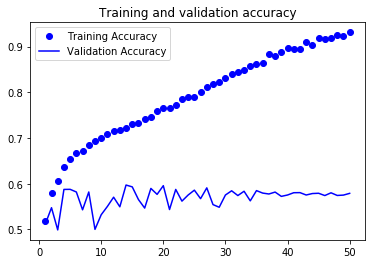

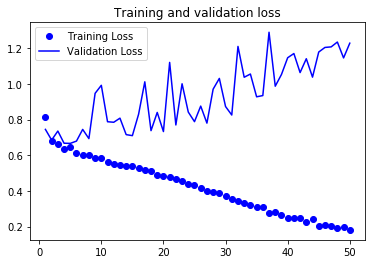

In [19]:
# Plotting the data 

# Training + Valdiation Accuracy
epochs = range(1,len(acc) + 1)
plt.plot( epochs, acc, 'bo', label = 'Training Accuracy')
plt.plot( epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Training + Validation Loss
plt.plot( epochs, loss, 'bo', label = 'Training Loss')
plt.plot( epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

What do you think of these loss curves? What might we changes in the model?

**Exercise**: Change the model using some techniques we've learned about in this class and refit. 